<center style="font-weight:bold;font-size:20px">wbenbihi/hourglasstensorlfow: Stacked Hourglass Network for Human Pose Estimation</center>

<center style="font-weight:bold;font-size:20px">Model Illustration</center>

# Setup

## Imports

In [1]:
import os
import sys
sys.path.append(os.path.join('..'))

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
from config import CFG
from skimage.io import imread
from skimage.transform import resize
sns.set()

## Global Variables

In [3]:
ROOT_FOLDER = CFG.ROOT_FOLDER
DATA_FOLDER = 'data'
IMAGE_FOLDER = 'images'
LABELS_FILE = "MPII_DATASET_LABELS.csv"

# Function definition

# Main Code

## Model Coherence Check

In [4]:
print("Model Input Size:", CFG.default.HOURGLASS.inputsize)
print("Model Output Size:", CFG.default.HOURGLASS.outputsize)

Model Input Size: 256
Model Output Size: 64


The first element to check is the integer coefficient between input and output size to determine the number of downsizing.

In [5]:
assert (CFG.default.HOURGLASS.inputsize / CFG.default.HOURGLASS.outputsize).is_integer(), 'InputSize is not divisible by OutputSize'
PREPROCESS_DOWNSIZING = int(CFG.default.HOURGLASS.inputsize / CFG.default.HOURGLASS.outputsize) -1

We then check if our input image mode is genuine to define the channel numbers

In [6]:
assert CFG.default.HOURGLASS.inputmode in ["RGB", "BGR", "HSV", "HSL", "GRAY"], 'The input image mode is not recognized'
if CFG.default.HOURGLASS.inputmode in ["RGB", "BGR", "HSV", "HSL"]:
    CHANNELS = 3
elif CFG.default.HOURGLASS.inputmode in ["GRAY"]:
    CHANNELS = 1

## Layer Definition

To illustrate our model creation we'll use `tf.keras` API.

In [7]:
def conv_2d(input_tensor, filters, kernel_size, strides=1, activation=None, kernel_initializer='glorot_uniform',padding="same", prefix=""):
    x = tf.keras.layers.Conv2D(
        filters=filters,
        kernel_size=kernel_size,
        strides=strides,
        padding=padding,
        name=prefix+"conv_2d",
        activation=activation,
        kernel_initializer=kernel_initializer,
    )(input_tensor)
    return x

In [8]:
def batch_norm(input_tensor, momentum=0.9, epsilon=1e-5, trainable=True, prefix=""):
    x = tf.keras.layers.BatchNormalization(
        axis=-1,
        momentum=momentum,
        epsilon=epsilon,
        trainable=trainable,
        name=prefix+"batch_norm",
    )(input_tensor)
    return x

In [9]:
def conv_batch_norm_relu(input_tensor, filters, kernel_size, strides=1, activation=None, kernel_initializer='glorot_uniform',padding="same", prefix="", momentum=0.9, epsilon=1e-5, trainable=True):
    x = conv_2d(
        input_tensor=input_tensor,
        filters=filters,
        kernel_size=kernel_size,
        strides=strides,
        activation=activation,
        kernel_initializer=kernel_initializer,
        padding=padding,
        prefix=prefix+'conv_bn_relu_'
    )
    x = batch_norm(
        x, 
        momentum=0.9, 
        epsilon=1e-5, 
        trainable=True,
        prefix=prefix+'conv_bn_relu_'
    )
    x = tf.keras.layers.ReLU(name=prefix+"relu")(x)
    return x

In [10]:
def conv_block(input_tensor, numOut, prefix="", trainable=True):
    x = batch_norm(input_tensor, momentum=0.9, epsilon=1e-5, trainable=True, prefix=prefix+"conv_block_1_")
    x = tf.keras.layers.ReLU(name=prefix+"conv_block_1_relu")(x)
    x = conv_2d(x, filters=numOut//2, kernel_size=1, strides=1, padding="same", prefix=prefix+"conv_block_1_")
    
    x = batch_norm(x, momentum=0.9, epsilon=1e-5, trainable=True, prefix=prefix+"conv_block_2_")
    x = tf.keras.layers.ReLU(name=prefix+"conv_block_2_relu")(x)
    x = conv_2d(x, filters=numOut//2, kernel_size=3, strides=1, padding="same", prefix=prefix+"conv_block_2_")
    
    x = batch_norm(x, momentum=0.9, epsilon=1e-5, trainable=True, prefix=prefix+"conv_block_3_")
    x = tf.keras.layers.ReLU(name=prefix+"conv_block_3_relu")(x)
    x = conv_2d(x, filters=numOut, kernel_size=1, strides=1, padding="same", prefix=prefix+"conv_block_3_")
    return x

In [11]:
def skip_layer(input_tensor, numOut, prefix=""):
    if input_tensor.get_shape().as_list()[-1] == numOut:
        return input_tensor
    else:
        x = conv_2d(input_tensor, filters=numOut, kernel_size=1, strides=1, padding="same", prefix=prefix+"skip_layer_")
        return x

In [12]:
def residual(input_tensor, numOut, prefix="", trainable=True):
    convb = conv_block(input_tensor, numOut, prefix=prefix+"residual_", trainable=trainable)
    skipl = skip_layer(input_tensor, numOut, prefix=prefix+"residual_")
    return tf.add_n([convb, skipl], name=prefix+"residual_add")

In [13]:
input_tensor = tf.keras.layers.Input(
    shape=(CFG.default.HOURGLASS.inputsize, CFG.default.HOURGLASS.inputsize, CHANNELS),
    name="demo_input_layer"
)

In [14]:
input_tensor

<tf.Tensor 'demo_input_layer:0' shape=(None, 256, 256, 3) dtype=float32>

In [15]:
for i in range(PREPROCESS_DOWNSIZING):
    if i == 0:
        x = conv_batch_norm_relu(input_tensor, filters=64, kernel_size=6, strides=2, prefix=f"downsample_{i}_")
    elif i < PREPROCESS_DOWNSIZING - 1:
        x = residual(x, numOut=128, prefix=f"downsample_{i}_")
        x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding="same", name=f"downsample_{i}_maxpool")(x)
    else:
        x = residual(x, numOut=256, prefix=f"downsample_{i}_")
autoencoder_input_tensor = x

In [16]:
autoencoder_input_tensor

<tf.Tensor 'downsample_2_residual_add:0' shape=(None, 64, 64, 256) dtype=float32>

Our downsampling to the outputSize dimension is now complete. We can visualize the graph for the downsampling step.

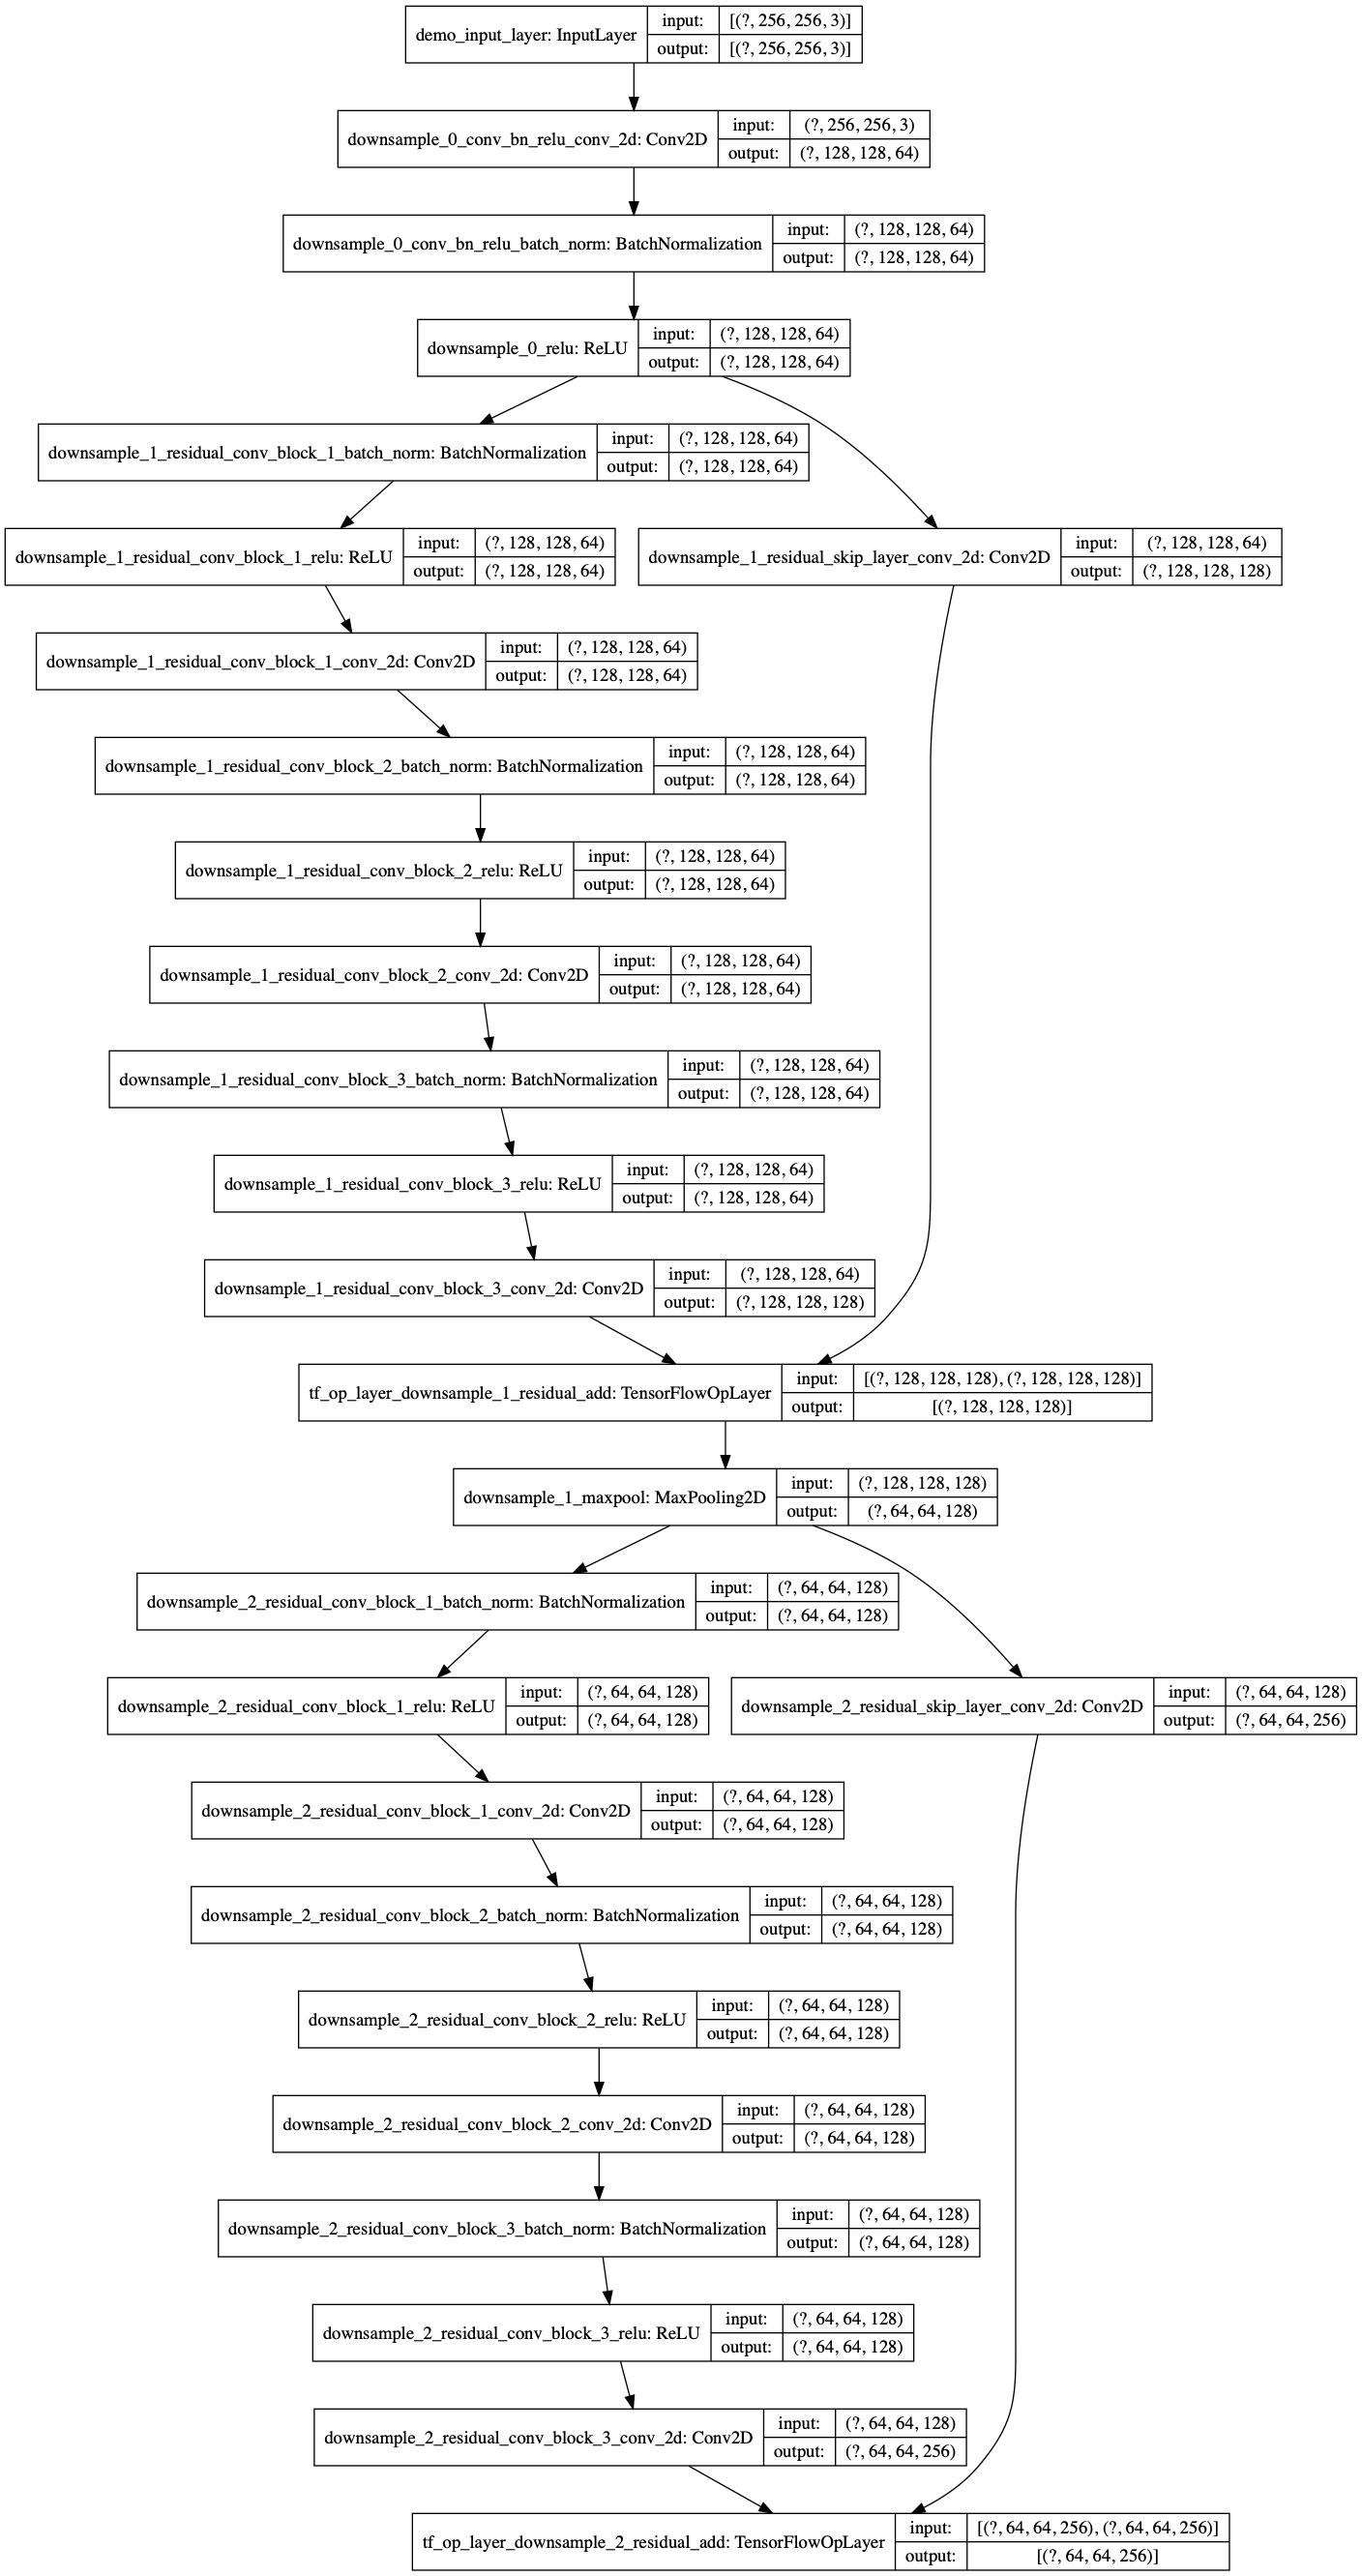

In [19]:
# We use the built-in keras method to visualize the graph.
# To replicate this cell you might need to install graphviz
# brew install graphviz
fake_model = tf.keras.Model(
    inputs = input_tensor,
    outputs=autoencoder_input_tensor,
)
tf.keras.utils.plot_model(fake_model, show_shapes=True)

As we can see, many basic layers are replicated over the graph, leading to low readability. For the purpose of this notebook we'll continue to develop the architecture with the same methodology and we'll provide another implementation with high level blocks to facilitate the graph understanding.

In [31]:
def hourglass(input_tensor, downsampling_steps, numOut, prefix=""):
    up_1 = residual(input_tensor, numOut=numOut, prefix=prefix+"up_1_")
    low_ = tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding="same", name=prefix+f"maxpool_{downsampling_steps}_")(input_tensor)
    low_1 = residual(low_, numOut=numOut, prefix=prefix+"low_1_")
    if downsampling_steps > 0:
        low_2 = hourglass(low_1, downsampling_steps=downsampling_steps-1, numOut=numOut, prefix=prefix+"low_2_")
    else:
        low_2 = residual(low_1, numOut=numOut, prefix=prefix+"low_2_")
    low_3 = residual(low_2, numOut=numOut, prefix=prefix+"low_3_")
    up_2 = tf.image.resize(low_3,size=tf.shape(low_3)[1:3]*2, method="nearest", name=prefix+'upsampling')
    return tf.add_n([up_2,up_1], name='out_hg')

In [35]:
out_hg = hourglass(autoencoder_input_tensor, 3, numOut=256, prefix="hg_")

To illustrate our previous point on readability, we plot the graph for a single Hourglass/Autoencoder and we display the `tf.keras.Model.summary()` to grasp the need for reading ease.

In [36]:
fake_model = tf.keras.Model(
    inputs = input_tensor,
    outputs= out_hg,
)
tf.keras.utils.plot_model(fake_model, show_shapes=True)

In [37]:
fake_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
demo_input_layer (InputLayer)   [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
downsample_0_conv_bn_relu_conv_ (None, 128, 128, 64) 6976        demo_input_layer[0][0]           
__________________________________________________________________________________________________
downsample_0_conv_bn_relu_batch (None, 128, 128, 64) 256         downsample_0_conv_bn_relu_conv_2d
__________________________________________________________________________________________________
downsample_0_relu (ReLU)        (None, 128, 128, 64) 0           downsample_0_conv_bn_relu_batch_n
____________________________________________________________________________________________

So far we have a trainable model with a single Houglass network, we will not build the full model in this notebook as it is simply a stacking _(for loop)_.

One improvement we'll make versus the previous version of `wbenbihi/hourglasstensorlfow` is to package some redundant graph blocks as `tf.keras.Layer` child classes.